In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Sampling from a prior

In Bayes-land, we predict stuff by taking the product of our prior beliefs and the data we have seen so far. Frequentists take point estimates from this, Bayesians use this product to construct a new _posterior distribution_ that tells us how certain we are for various subsections of the input space.  

Sampling from a prior is weird, so I'm going to give an example of how we can construct candidates for linear regression using a multivariate Gaussian.

The model for a straight line fit is:

\begin{align}
f(x;w) = w_1 x + w_2, \hspace{2cm}
p(y \mid x, w) = \mathcal{N}(y; f(x;w), \sigma_y^2)
\end{align}

`w` in this case is a vector [w1,w2]. We can put a prior on the values of w and examine the possible functions it generates:

\begin{align}
p(w) = \mathcal{N}(w; 0.2, 0.1)
\end{align}

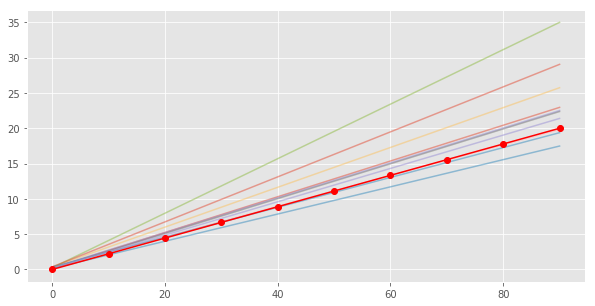

In [2]:
train_x = np.linspace(0,90,10)
train_y = np.linspace(0,20,10)

def model(w_1, w_2, x):
    return (w_1 * x) + w_2
    
fig, ax = plt.subplots(figsize=(10,5))

# sample 10 random functions from p_w
for n in range(10):
    w_n = np.random.normal(0.2,0.1,2)
    
    f_x = []
    for x in train_x:
        f_x.append(model(w_n[0],w_n[1],x))
    
    ax.plot(train_x, f_x, alpha=0.5)

ax.plot(train_x,train_y,marker='o', color='red')
plt.show()

The dotted red line shows the training data, and the other lines are all samples from our prior. We want to _reweight_ the prior using a likelihood. In the linear case, we can do this via _Maximum Likelihood Estimation_, which is easy but boring so I'm going to move on to something more fun.

## Gaussian Processes

A Gaussian Process is a _distribution over functions_. When we sample from a Gaussian process, we are given a mean and variance which we can plug into a normal distribution, which we can sample from to get guesses for what our data might be at a new input location.   

In order to sample from a Gaussian process, the normal distribution must have mean 0 and the identity covariance. In the univariate case, we can express a non-zero mean Gaussian as:

\begin{align}
x \sim \mathcal{N}(\mu, \sigma^2) \\
x \sim \mu + \sigma (\mathcal{N}(0,1))
\end{align}

In the multivariate case, we have a covariance matrix instead of a scalar variance. We therefore need to do Cholesky decomposition on $K$ before we sample:

\begin{align}
x \sim \mathcal{N}(\mu, K) \\
x \sim \mu + L (\mathcal{N}(0,I))
\end{align}

Recall that Cholesky decomposition gives us $K = LL^T$. 

So before we see any data, let's sample from our Gaussian Process. We set up a normal distribution with mean zero and covariance given by the squared exponential (a standard choice). In order to sample from our multivariate, we use the above equation:

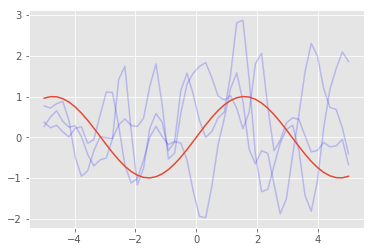

In [3]:
# param can be learned via maximising log likelihood 
def kernel(a,b,param=0.1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    k = np.exp(-.5 * (1/param) * sqdist)
    return k

# training data space 
X = np.linspace(-5,5,50).reshape(-1,1)
x = np.linspace(-5,5,50)
y = np.sin(X)

# get three sets of 10 points
L   = np.linalg.cholesky(kernel(X,X)) # K = L * L.T
f_i = np.dot(L, np.random.normal(size=(50,3)))

# plot some samples
fig, ax = plt.subplots()
ax.plot(x, f_i,color='blue', alpha=0.2)
ax.plot(x, y)
plt.show()

Some linear algebra gruntwork gives us a rule for computing the conditional Gaussian from a joint, which we can conveniently express as a system of linear equations. The key thing that is happening here is:

![resources/gp.png](resources/gp.png)

Which is to say, we have our training set labels $y$ and we have a new point $X_*$ for which would like to calculate $f_*$. We compute the covariance $K_* = K(X,X_*)$ and $K_{**} = K(X_*, X_*)$. This gives us a new Gaussian which we can sample from.

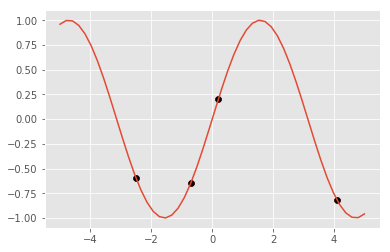

In [4]:
X_s  = np.array([-2.5,-.7,0.2,4.1]).reshape(-1,1) # we'd like to predict values for some new points

K     = kernel(X,X)
K_s   = kernel(X,X_s)
K_s_s = kernel(X_s,X_s)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, X_s))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(X_s, X_s)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s  = np.sqrt(s2)

### now we can do the same thing as above - for our 4 points we sample 4 values
L = np.linalg.cholesky(K_ - np.dot(Lk.T, Lk))
mu = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(4,1)))
 
fig,ax = plt.subplots()
ax.plot(x,y)
ax.scatter(X_s,np.sin(X_s))
ax.scatter(X_s,mu,color='black')
plt.show()